In [1]:
!pip install pillow-heif ipycanvas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 11.1 MB/s eta 0:00:00


since the sample dataset is HEI, in order to allow our team members to experiment we can (1) add some codeblock to convert all of the images to png (2) adapt this code so it runs on Google c

In [2]:
!ls /kaggle/input/sand-samples/sand

IMG_1620.HEIC  IMG_1625.HEIC  IMG_1630.HEIC  IMG_1635.HEIC  IMG_1640.HEIC
IMG_1621.HEIC  IMG_1626.HEIC  IMG_1631.HEIC  IMG_1636.HEIC  IMG_1641.HEIC
IMG_1622.HEIC  IMG_1627.HEIC  IMG_1632.HEIC  IMG_1637.HEIC  IMG_1642.HEIC
IMG_1623.HEIC  IMG_1628.HEIC  IMG_1633.HEIC  IMG_1638.HEIC
IMG_1624.HEIC  IMG_1629.HEIC  IMG_1634.HEIC  IMG_1639.HEIC


### File format coversion

In [3]:
# style_transfer_lib.py

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image

# Set the main device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_image(image_path, target_size=512):
    image = Image.open(image_path).convert('RGB')
    transform_pipeline = transforms.Compose([
        transforms.Resize(target_size),      # Resize the smaller edge to target_size
        transforms.CenterCrop(target_size),    # Center crop to target_size x target_size
        transforms.ToTensor(),                 # Convert image to tensor in [0,1] range
    ])
    image_tensor = transform_pipeline(image).unsqueeze(0)  # Shape: [1, C, H, W]
    return image_tensor.to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # Reshape mean and std for proper broadcasting
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std  = torch.tensor(std).view(-1, 1, 1).to(device)
    def forward(self, img):
        return (img - self.mean) / self.std

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = None
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input_tensor):
    b, ch, h, w = input_tensor.size()
    features = input_tensor.view(b * ch, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * ch * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = None
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Default layers at which to compute losses
content_layers_default = ['conv_4']
style_layers_default   = ['conv_1','conv_2','conv_3','conv_4','conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    
    normalization = Normalization(normalization_mean, normalization_std)
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0  # increment for each conv layer
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)  # Replace in-place ReLU
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim layers after the last loss module
    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
            break
    model = model[:(j + 1)]
    
    return model, style_losses, content_losses

def get_input_optimizer(input_img):
    # Use LBFGS as in the PyTorch tutorial
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, 
                       num_steps=300, style_weight=1_000_000, content_weight=1):
    
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std, style_img, content_img
    )
    
    optimizer = get_input_optimizer(input_img)
    run = [0]

    while run[0] <= num_steps:
        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            
            style_score = 0.0
            content_score = 0.0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            
            loss = style_weight * style_score + content_weight * content_score
            loss.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print(f"Iteration {run[0]}: Style Loss {style_score.item():.4f}, Content Loss {content_score.item():.4f}")
            return loss
        optimizer.step(closure)
    
    with torch.no_grad():
        input_img.clamp_(0, 1)
    
    return input_img

def process_style_transfer(config):
    """
    Process all PNG content images from config["input_dir"] using the first PNG
    style image found in config["style_dir"]. The stylized images will be saved
    in config["output_dir"].
    """
    # Load style image (only use the first PNG found)
    style_files = [f for f in os.listdir(config["style_dir"]) if f.lower().endswith(".png")]
    if not style_files:
        raise ValueError("No PNG style images found in the style directory.")
    style_image_path = os.path.join(config["style_dir"], style_files[0])
    style_img = load_image(style_image_path, target_size=config.get("target_size", 512))
    
    # Create output directory if it doesn't exist
    os.makedirs(config["output_dir"], exist_ok=True)
    
    # Load the CNN model (default VGG19)
    cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()
    cnn_mean = [0.485, 0.456, 0.406]
    cnn_std  = [0.229, 0.224, 0.225]
    
    # Process each PNG image in the input directory
    input_files = [f for f in os.listdir(config["input_dir"]) if f.lower().endswith(".png")]
    if not input_files:
        raise ValueError("No PNG content images found in the input directory.")
    
    for img_file in input_files:
        print(f"Processing {img_file}...")
        content_image_path = os.path.join(config["input_dir"], img_file)
        content_img = load_image(content_image_path, target_size=config.get("target_size", 512))
        input_img = content_img.clone()
        
        output_tensor = run_style_transfer(
            cnn, cnn_mean, cnn_std,
            content_img, style_img, input_img,
            num_steps=config.get("num_steps", 300),
            style_weight=config.get("style_weight", 1_000_000),
            content_weight=config.get("content_weight", 1)
        )
        output_tensor = output_tensor.cpu().squeeze(0)
        output_image = transforms.ToPILImage()(output_tensor)
        base_name, _ = os.path.splitext(img_file)
        output_path = os.path.join(config["output_dir"], f"{base_name}_styled.png")
        output_image.save(output_path)
        print(f"Saved styled image to {output_path}")


In [4]:
# config.py

config = {
    "input_dir": "/kaggle/input/isolate",    # Directory containing PNG content images
    "output_dir": "/kaggle/working/output",    # Directory to store stylized images
    "style_dir": "/kaggle/input/earth-inspo",      # Directory containing style images (only first PNG is used)
    "num_steps": 1000,         # Number of iterations (intensity of style transfer)
    "style_weight": 1_000_000, # Weight for style loss
    "content_weight": 1,       # Weight for content loss
    "target_size": 512,        # (Optional) Resize images to this size
}

In [5]:
# run_style_transfer.py

process_style_transfer(config)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 210MB/s]


Processing isolate.png...
Iteration 50: Style Loss 0.0000, Content Loss 37.2802
Iteration 100: Style Loss 0.0000, Content Loss 31.8524
Iteration 150: Style Loss 0.0000, Content Loss 28.0936
Iteration 200: Style Loss 0.0000, Content Loss 25.7802
Iteration 250: Style Loss 0.0000, Content Loss 24.5709
Iteration 300: Style Loss 0.0000, Content Loss 23.8943
Iteration 350: Style Loss 0.0000, Content Loss 23.4732
Iteration 400: Style Loss 0.0000, Content Loss 23.1883
Iteration 450: Style Loss 0.0000, Content Loss 22.9999
Iteration 500: Style Loss 0.0000, Content Loss 22.8708
Iteration 550: Style Loss 0.0000, Content Loss 22.7777
Iteration 600: Style Loss 0.0000, Content Loss 22.7114
Iteration 650: Style Loss 0.0000, Content Loss 22.6583
Iteration 700: Style Loss 0.0000, Content Loss 22.6159
Iteration 750: Style Loss 0.0000, Content Loss 22.5793
Iteration 800: Style Loss 0.0000, Content Loss 22.5498
Iteration 850: Style Loss 0.0000, Content Loss 22.5254
Iteration 900: Style Loss 0.0000, Conten

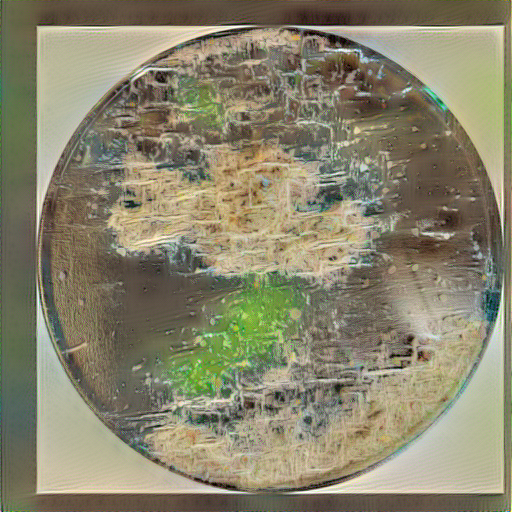

In [6]:
from IPython.display import display, Image

output_image = '/kaggle/working/output/isolate_styled.png'

display(Image(filename=output_image))